# Melbourne Parking Data Exploration
# 01_data_exploration.ipynb

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
warnings.filterwarnings("ignore")

import sys
!{sys.executable} -m pip install folium
import folium
from folium.plugins import MarkerCluster


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [5]:
# Set Display options
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

## 1. Load All csv Files

In [6]:
print("MELBOURNE PARKING DATA EXPLORATION")
print("=" * 50)

# Load all 4 csv files
print("Loading CSV files...")

# Set base directory
base_dir = "./Datasets" 

# 1. Parking sensor data (real-time occupancy)
sensors_df = pd.read_csv(f"{base_dir}/on_street_parking_bay_sensors.csv")
print(f"Sensors data loaded: {sensors_df.shape[0]} rows, {sensors_df.shape[1]} columns")

# 2. All parking bay locations
bays_df = pd.read_csv(f"{base_dir}/on_street_parking_bays.csv")
print(f"Parking bays loaded: {bays_df.shape[0]} rows, {bays_df.shape[1]} columns")

# 3. Parking zones linked to street segments
zones_df = pd.read_csv(f"{base_dir}/parking_zones_linked_to_street_segments.csv")
print(f"Zone segments loaded: {zones_df.shape[0]} rows, {zones_df.shape[1]} columns")

# 4. Parking restrictions and time limits
restrictions_df = pd.read_csv(f"{base_dir}/sign_plates_located_in_each_parking_zone.csv")
print(f"Restrictions loaded: {restrictions_df.shape[0]} rows, {restrictions_df.shape[1]} columns")

MELBOURNE PARKING DATA EXPLORATION
Loading CSV files...
Sensors data loaded: 3309 rows, 6 columns
Parking bays loaded: 23864 rows, 7 columns
Zone segments loaded: 798 rows, 5 columns
Restrictions loaded: 2033 rows, 5 columns


## 2. Initial Data Overview

In [7]:
print("DATASET OVERVIEW")
print("=" * 50)

datasets = {
    'Sensors': sensors_df,
    'Parking Bays': bays_df, 
    'Zone Segments': zones_df,
    'Restrictions': restrictions_df
}

for name, df in datasets.items():
    print(f"\n{name}:")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


DATASET OVERVIEW

Sensors:
Shape: (3309, 6)
Columns: ['Lastupdated', 'Status_Timestamp', 'Zone_Number', 'Status_Description', 'KerbsideID', 'Location']
Memory usage: 0.97 MB

Parking Bays:
Shape: (23864, 7)
Columns: ['RoadSegmentID', 'KerbsideID', 'RoadSegmentDescription', 'Latitude', 'Longitude', 'LastUpdated', 'Location']
Memory usage: 6.78 MB

Zone Segments:
Shape: (798, 5)
Columns: ['ParkingZone', 'OnStreet', 'StreetFrom', 'StreetTo', 'Segment_ID']
Memory usage: 0.16 MB

Restrictions:
Shape: (2033, 5)
Columns: ['ParkingZone', 'Restriction_Days', 'Time_Restrictions_Start', 'Time_Restrictions_Finish', 'Restriction_Display']
Memory usage: 0.45 MB


## 3. Sensor Data Analysis (Most Important for Real-time Features)

In [8]:
print("SENSOR DATA")
print("=" * 50)

# Basic info
print("Basic Information:")
print(sensors_df.info())

SENSOR DATA
Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3309 entries, 0 to 3308
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Lastupdated         3309 non-null   object 
 1   Status_Timestamp    3309 non-null   object 
 2   Zone_Number         3081 non-null   float64
 3   Status_Description  3309 non-null   object 
 4   KerbsideID          3309 non-null   int64  
 5   Location            3309 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 155.2+ KB
None


In [9]:
print("\nColumn Details:")
for col in sensors_df.columns:
    print(f"{col}:")
    print(f"- Non-null count: {sensors_df[col].count()}")
    print(f"- Null count: {sensors_df[col].isnull().sum()}")
    print(f"- Data type: {sensors_df[col].dtype}")
    if sensors_df[col].dtype == 'object':
        print(f"- Unique values: {sensors_df[col].nunique()}")
        print(f"- Sample values: {sensors_df[col].value_counts().head(3).to_dict()}")
    print()


Column Details:
Lastupdated:
- Non-null count: 3309
- Null count: 0
- Data type: object
- Unique values: 29
- Sample values: {'2025-08-08T15:47:39+10:00': 2861, '2025-06-10T09:44:34+10:00': 63, '2025-06-23T15:44:34+10:00': 45}

Status_Timestamp:
- Non-null count: 3309
- Null count: 0
- Data type: object
- Unique values: 3000
- Sample values: {'2025-08-08T15:44:36+10:00': 5, '2025-08-08T15:33:54+10:00': 4, '2025-08-08T15:41:46+10:00': 4}

Zone_Number:
- Non-null count: 3081
- Null count: 228
- Data type: float64

Status_Description:
- Non-null count: 3309
- Null count: 0
- Data type: object
- Unique values: 2
- Sample values: {'Unoccupied': 1670, 'Present': 1639}

KerbsideID:
- Non-null count: 3309
- Null count: 0
- Data type: int64

Location:
- Non-null count: 3309
- Null count: 0
- Data type: object
- Unique values: 3309
- Sample values: {'-37.8233950937474, 144.96674793778274': 1, '-37.80983351519755, 144.97896296293217': 1, '-37.816551478301335, 144.95912673787493': 1}



### 3.1 Occupancy Analysis

In [10]:
print("PARKING OCCUPANCY ANALYSIS")
print("=" * 50)

# Clean status description
sensors_df['Status_Description'] = sensors_df['Status_Description'].str.strip()

# Occupancy breakdown
occupancy_counts = sensors_df['Status_Description'].value_counts()
total_sensors = len(sensors_df)

print("Current Occupancy Status:")
for status, count in occupancy_counts.items():
    percentage = (count / total_sensors) * 100
    print(f"  {status}: {count} sensors ({percentage:.1f}%)")

PARKING OCCUPANCY ANALYSIS
Current Occupancy Status:
  Unoccupied: 1670 sensors (50.5%)
  Present: 1639 sensors (49.5%)


### 3.2 Geographic Distribution Analysis

In [11]:
print("\nGEOGRAPHIC ANALYSIS")
print("=" * 50)

# Clean location data for sensors
print("Cleaning sensor location data...")
sensors_df['Location_clean'] = sensors_df['Location'].str.strip('"')
location_split = sensors_df['Location_clean'].str.split(', ', expand=True)
sensors_df['latitude'] = pd.to_numeric(location_split[0], errors='coerce')
sensors_df['longitude'] = pd.to_numeric(location_split[1], errors='coerce')

# Remove invalid coordinates
valid_coords = sensors_df['latitude'].notna() & sensors_df['longitude'].notna()
sensors_clean = sensors_df[valid_coords].copy()

print(f"Valid coordinates: {valid_coords.sum()} out of {len(sensors_df)}")
print(f"Latitude range: {sensors_clean['latitude'].min():.6f} to {sensors_clean['latitude'].max():.6f}")
print(f"Longitude range: {sensors_clean['longitude'].min():.6f} to {sensors_clean['longitude'].max():.6f}")



GEOGRAPHIC ANALYSIS
Cleaning sensor location data...
Valid coordinates: 3309 out of 3309
Latitude range: -37.848238 to -37.794906
Longitude range: 144.936436 to 144.988612


In [12]:
# First, make sure you have the cleaned sensor data
# (Run this if you haven't already)
sensors_clean = sensors_df[sensors_df['Zone_Number'].notna()].copy()

# Parse coordinates for sensors_clean
coords = sensors_clean['Location'].str.strip('"').str.split(', ', expand=True)
sensors_clean['latitude'] = pd.to_numeric(coords[0], errors='coerce')
sensors_clean['longitude'] = pd.to_numeric(coords[1], errors='coerce')

# Remove any invalid coordinates
sensors_clean = sensors_clean[sensors_clean['latitude'].notna() & sensors_clean['longitude'].notna()]

# NOW create occupied and unoccupied DataFrames
occupied = sensors_clean[sensors_clean['Status_Description'] == 'Present'].copy()
unoccupied = sensors_clean[sensors_clean['Status_Description'] == 'Unoccupied'].copy()

print(f"   Occupied sensors: {len(occupied)}")
print(f"   Available sensors: {len(unoccupied)}")
print(f"   Total sensors: {len(sensors_clean)}")

# Create Melbourne-centered map
melbourne_center = [-37.8136, 144.9631]
m = folium.Map(location=melbourne_center, zoom_start=13, tiles='OpenStreetMap')

# Sample data for faster rendering (optional)
occupied_sample = occupied.head(100)  # First 100 for speed
unoccupied_sample = unoccupied.head(100)

print(f"Plotting {len(occupied_sample)} occupied and {len(unoccupied_sample)} available spots...")

# Add occupied sensors (red)
for idx, sensor in occupied_sample.iterrows():
    folium.CircleMarker(
        location=[sensor['latitude'], sensor['longitude']],
        radius=5,
        popup=f"Zone {sensor['Zone_Number']}: Occupied<br>KerbsideID: {sensor['KerbsideID']}",
        color='red',
        fill=True,
        fillOpacity=0.7
    ).add_to(m)

# Add available sensors (green)
for idx, sensor in unoccupied_sample.iterrows():
    folium.CircleMarker(
        location=[sensor['latitude'], sensor['longitude']],
        radius=5,
        popup=f"Zone {sensor['Zone_Number']}: Available<br>KerbsideID: {sensor['KerbsideID']}",
        color='green',
        fill=True,
        fillOpacity=0.7
    ).add_to(m)

# Add a simple legend
legend_html = '''
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 150px; height: 90px; 
            background-color: white; border:2px solid grey; z-index:9999; 
            font-size:14px; padding: 5px">
<h4>Parking Status</h4>
<p><span style="color:red;">●</span> Occupied</p>
<p><span style="color:green;">●</span> Available</p>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# Display map
m

   Occupied sensors: 1521
   Available sensors: 1560
   Total sensors: 3081
Plotting 100 occupied and 100 available spots...


### 3.3 Parking Zone Analysis

In [13]:
# Complete the zone analysis you started
print("PARKING ZONE ANALYSIS")
print("=" * 50)

# Zone distribution in sensor data
zones_with_sensors = sensors_clean['Zone_Number'].dropna()
print(f"Zones with sensor data: {zones_with_sensors.nunique()}")
print(f"Total zone records in sensors: {len(zones_with_sensors)}")

# Zone occupancy analysis
zone_occupancy = sensors_clean.groupby('Zone_Number').agg({
    'Status_Description': ['count', lambda x: (x == 'Present').sum()],
    'latitude': 'mean',
    'longitude': 'mean'
}).round(6)

zone_occupancy.columns = ['total_sensors', 'occupied_sensors', 'avg_lat', 'avg_lng']
zone_occupancy['occupancy_rate'] = zone_occupancy['occupied_sensors'] / zone_occupancy['total_sensors']
zone_occupancy['available_sensors'] = zone_occupancy['total_sensors'] - zone_occupancy['occupied_sensors']

print("\nTop 5 Busiest Zones (by occupancy rate):")
busiest_zones = zone_occupancy.sort_values('occupancy_rate', ascending=False).head(5)
print(busiest_zones[['total_sensors', 'occupied_sensors', 'occupancy_rate']])

print("\nTop 5 Most Available Zones:")
available_zones = zone_occupancy.sort_values('occupancy_rate', ascending=True).head(5)
print(available_zones[['total_sensors', 'occupied_sensors', 'occupancy_rate']])

PARKING ZONE ANALYSIS
Zones with sensor data: 331
Total zone records in sensors: 3081

Top 5 Busiest Zones (by occupancy rate):
             total_sensors  occupied_sensors  occupancy_rate
Zone_Number                                                 
7639.0                  18                18             1.0
7212.0                   5                 5             1.0
7379.0                   4                 4             1.0
7185.0                   3                 3             1.0
7644.0                   4                 4             1.0

Top 5 Most Available Zones:
             total_sensors  occupied_sensors  occupancy_rate
Zone_Number                                                 
7995.0                   1                 0             0.0
7792.0                   2                 0             0.0
7520.0                   7                 0             0.0
7512.0                   5                 0             0.0
7769.0                   6                 0      

In [14]:
# Create Melbourne-centered map
melbourne_center = [-37.8136, 144.9631]
m = folium.Map(location=melbourne_center, zoom_start=13)

print("Map with top 5 busiest and most available zones...")

# Function to get zone color based on occupancy
def get_zone_color(occupancy_rate):
    if occupancy_rate > 0.8:
        return 'red'      # Very busy
    elif occupancy_rate > 0.6:
        return 'orange'   # Busy
    elif occupancy_rate > 0.4:
        return 'yellow'   # Moderate
    else:
        return 'green'    # Available

# Add TOP 5 BUSIEST zones (red/orange markers)
for idx, zone in busiest_zones.iterrows():
    zone_id = int(idx)
    color = get_zone_color(zone['occupancy_rate'])
    
    folium.Marker(
        location=[zone['avg_lat'], zone['avg_lng']],
        popup=f"""
        <b>  BUSY Zone {zone_id}</b><br>
        Occupancy: {zone['occupancy_rate']:.1%}<br>
        Occupied: {int(zone['occupied_sensors'])}/{int(zone['total_sensors'])} sensors<br>
        Available: {int(zone['available_sensors'])} spots
        """,
        icon=folium.Icon(color='red', icon='exclamation-sign', prefix='fa'),
        tooltip=f"Busy Zone {zone_id}: {zone['occupancy_rate']:.1%}"
    ).add_to(m)

# Add TOP 5 MOST AVAILABLE zones (green markers)
for idx, zone in available_zones.iterrows():
    zone_id = int(idx)
    color = get_zone_color(zone['occupancy_rate'])
    
    folium.Marker(
        location=[zone['avg_lat'], zone['avg_lng']],
        popup=f"""
        <b>  AVAILABLE Zone {zone_id}</b><br>
        Occupancy: {zone['occupancy_rate']:.1%}<br>
        Occupied: {int(zone['occupied_sensors'])}/{int(zone['total_sensors'])} sensors<br>
        Available: {int(zone['available_sensors'])} spots
        """,
        icon=folium.Icon(color='green', icon='ok-sign', prefix='fa'),
        tooltip=f"Available Zone {zone_id}: {zone['occupancy_rate']:.1%}"
    ).add_to(m)

# Add custom legend
legend_html = '''
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 200px; height: 100px; 
            background-color: white; border:2px solid grey; z-index:9999; 
            font-size:12px; padding: 15px; border-radius: 5px;">
<h4 style="margin-top:0;">Zone Analysis</h4>
<p><i class="fa fa-map-marker" style="color:red;"></i> Top 5 Busiest Zones</p>
<p><i class="fa fa-map-marker" style="color:green;"></i> Top 5 Available Zones</p>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# Display the map
m

Map with top 5 busiest and most available zones...


## 4. Parking Bays Analysis

In [15]:
print("  PARKING BAYS DETAILED ANALYSIS")
print("=" * 50)

# 1. Sensor Coverage Analysis
sensor_coverage = (5339 / 23864) * 100
print(f"Sensor coverage: {sensor_coverage:.1f}% of parking bays have sensors")
print(f"Non-sensor bays: {23864 - 5339:,} locations without occupancy monitoring")

# 2. Geographic Distribution
print(f"\nGeographic spread:")
print(f"Latitude range: {bays_df['Latitude'].min():.6f} to {bays_df['Latitude'].max():.6f}")
print(f"Longitude range: {bays_df['Longitude'].min():.6f} to {bays_df['Longitude'].max():.6f}")

# 3. Road Segment Analysis
print(f"\nRoad segment insights:")
segments_per_street = bays_df.groupby('RoadSegmentDescription').size()
print(f"Average bays per street: {segments_per_street.mean():.1f}")
print(f"Most dense street: {segments_per_street.max()} bays")
print(f"Streets with 1 bay only: {(segments_per_street == 1).sum()}")

# 4. Data Quality Check
print(f"\nData quality:")
missing_kerbside = bays_df['KerbsideID'].isnull().sum()
print(f"Missing KerbsideID: {missing_kerbside:,} ({missing_kerbside/len(bays_df)*100:.1f}%)")

# 5. Key Insight for Your Project
print(f"\nKEY INSIGHT FOR THE PROJECT:")
print(f"Total parking locations: {len(bays_df):,}")
print(f"Locations with sensors: {5339:,} ({sensor_coverage:.1f}%)")
print(f"Locations without sensors: {missing_kerbside:,} ({(missing_kerbside/len(bays_df)*100):.1f}%)")
print(f"You can show ALL locations but only {sensor_coverage:.1f}% have live occupancy data")

  PARKING BAYS DETAILED ANALYSIS
Sensor coverage: 22.4% of parking bays have sensors
Non-sensor bays: 18,525 locations without occupancy monitoring

Geographic spread:
Latitude range: -37.850542 to -37.775627
Longitude range: 144.900583 to 144.990748

Road segment insights:
Average bays per street: 19.0
Most dense street: 298 bays
Streets with 1 bay only: 136

Data quality:
Missing KerbsideID: 18,525 (77.6%)

KEY INSIGHT FOR THE PROJECT:
Total parking locations: 23,864
Locations with sensors: 5,339 (22.4%)
Locations without sensors: 18,525 (77.6%)
You can show ALL locations but only 22.4% have live occupancy data


## 5. PARKING RESTRICTIONS ANALYSIS

In [16]:
print("PARKING RESTRICTIONS ANALYSIS")
print("=" * 50)

print("Restrictions dataset overview:")
print(restrictions_df.info())
print()

# Basic stats
print(f"Total restriction records: {len(restrictions_df)}")
print(f"Unique parking zones with restrictions: {restrictions_df['ParkingZone'].nunique()}")
print(f"Zones per restriction (avg): {len(restrictions_df) / restrictions_df['ParkingZone'].nunique():.1f}")

# Analyze restriction types
print("\nPARKING RESTRICTION TYPES:")
restriction_types = restrictions_df['Restriction_Display'].value_counts()
print("Top 10 restriction types:")
for restriction, count in restriction_types.head(10).items():
    percentage = (count / len(restrictions_df)) * 100
    print(f"  {restriction}: {count} zones ({percentage:.1f}%)")

# Analyze restriction days
print("\nRESTRICTION DAYS:")
restriction_days = restrictions_df['Restriction_Days'].value_counts()
print("When restrictions apply:")
for day, count in restriction_days.items():
    percentage = (count / len(restrictions_df)) * 100
    print(f"  {day}: {count} zones ({percentage:.1f}%)")

# Analyze time restrictions
print("\nTIME RESTRICTIONS:")
print("Most common start times:")
start_times = restrictions_df['Time_Restrictions_Start'].value_counts().head(8)
for time, count in start_times.items():
    print(f"  {time}: {count} zones")

print("\nMost common end times:")
end_times = restrictions_df['Time_Restrictions_Finish'].value_counts().head(8)
for time, count in end_times.items():
    print(f"  {time}: {count} zones")

# Peak hour analysis
print("\nPEAK HOUR PATTERNS:")
# Convert times to datetime for analysis
restrictions_df['start_hour'] = pd.to_datetime(restrictions_df['Time_Restrictions_Start'], format='%H:%M:%S').dt.hour
restrictions_df['end_hour'] = pd.to_datetime(restrictions_df['Time_Restrictions_Finish'], format='%H:%M:%S').dt.hour

# Find common restriction hours
peak_start_hours = restrictions_df['start_hour'].value_counts().head(5)
peak_end_hours = restrictions_df['end_hour'].value_counts().head(5)

print("Most common restriction start hours:")
for hour, count in peak_start_hours.items():
    print(f"  {hour}:00 - {count} zones")

print("Most common restriction end hours:")
for hour, count in peak_end_hours.items():
    print(f"  {hour}:00 - {count} zones")

PARKING RESTRICTIONS ANALYSIS
Restrictions dataset overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2033 entries, 0 to 2032
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   ParkingZone               2033 non-null   int64 
 1   Restriction_Days          2033 non-null   object
 2   Time_Restrictions_Start   2033 non-null   object
 3   Time_Restrictions_Finish  2033 non-null   object
 4   Restriction_Display       2033 non-null   object
dtypes: int64(1), object(4)
memory usage: 79.5+ KB
None

Total restriction records: 2033
Unique parking zones with restrictions: 757
Zones per restriction (avg): 2.7

PARKING RESTRICTION TYPES:
Top 10 restriction types:
  MP2P: 1039 zones (51.1%)
  2P: 262 zones (12.9%)
  LZ30: 189 zones (9.3%)
  MP3P: 186 zones (9.1%)
  4P: 109 zones (5.4%)
  1P: 74 zones (3.6%)
  PP: 59 zones (2.9%)
  MP4P: 39 zones (1.9%)
  3P: 21 zones (1.0%)
  MP1P: 14 zones (0.7

In [17]:
print("\nKEY INSIGHTS FOR AC 2.2.1 (Time-based warnings):")
print("=" * 60)

# Identify business hours restrictions
business_hours = restrictions_df[
    (restrictions_df['Restriction_Days'].str.contains('Mon-Fri', na=False)) &
    (restrictions_df['start_hour'] <= 9) & 
    (restrictions_df['end_hour'] >= 17)
]

print(f"Business hour restrictions (Mon-Fri, covers 8-18): {len(business_hours)} zones")

# Weekend vs weekday
weekend_restrictions = restrictions_df[
    restrictions_df['Restriction_Days'].str.contains('Sat|Sun', na=False)
]
weekday_only = restrictions_df[
    restrictions_df['Restriction_Days'].str.contains('Mon-Fri', na=False)
]

print(f"Weekend restrictions: {len(weekend_restrictions)} zones")
print(f"Weekday-only restrictions: {len(weekday_only)} zones")

# Short-term vs long-term parking
short_term = restrictions_df[restrictions_df['Restriction_Display'].str.contains('1P|2P', na=False)]
long_term = restrictions_df[restrictions_df['Restriction_Display'].str.contains('4P|5P|6P', na=False)]

print(f"Short-term parking (1P-2P): {len(short_term)} zones")
print(f"Long-term parking (4P+): {len(long_term)} zones")


KEY INSIGHTS FOR AC 2.2.1 (Time-based warnings):
Business hour restrictions (Mon-Fri, covers 8-18): 395 zones
Weekend restrictions: 723 zones
Weekday-only restrictions: 1308 zones
Short-term parking (1P-2P): 1401 zones
Long-term parking (4P+): 150 zones


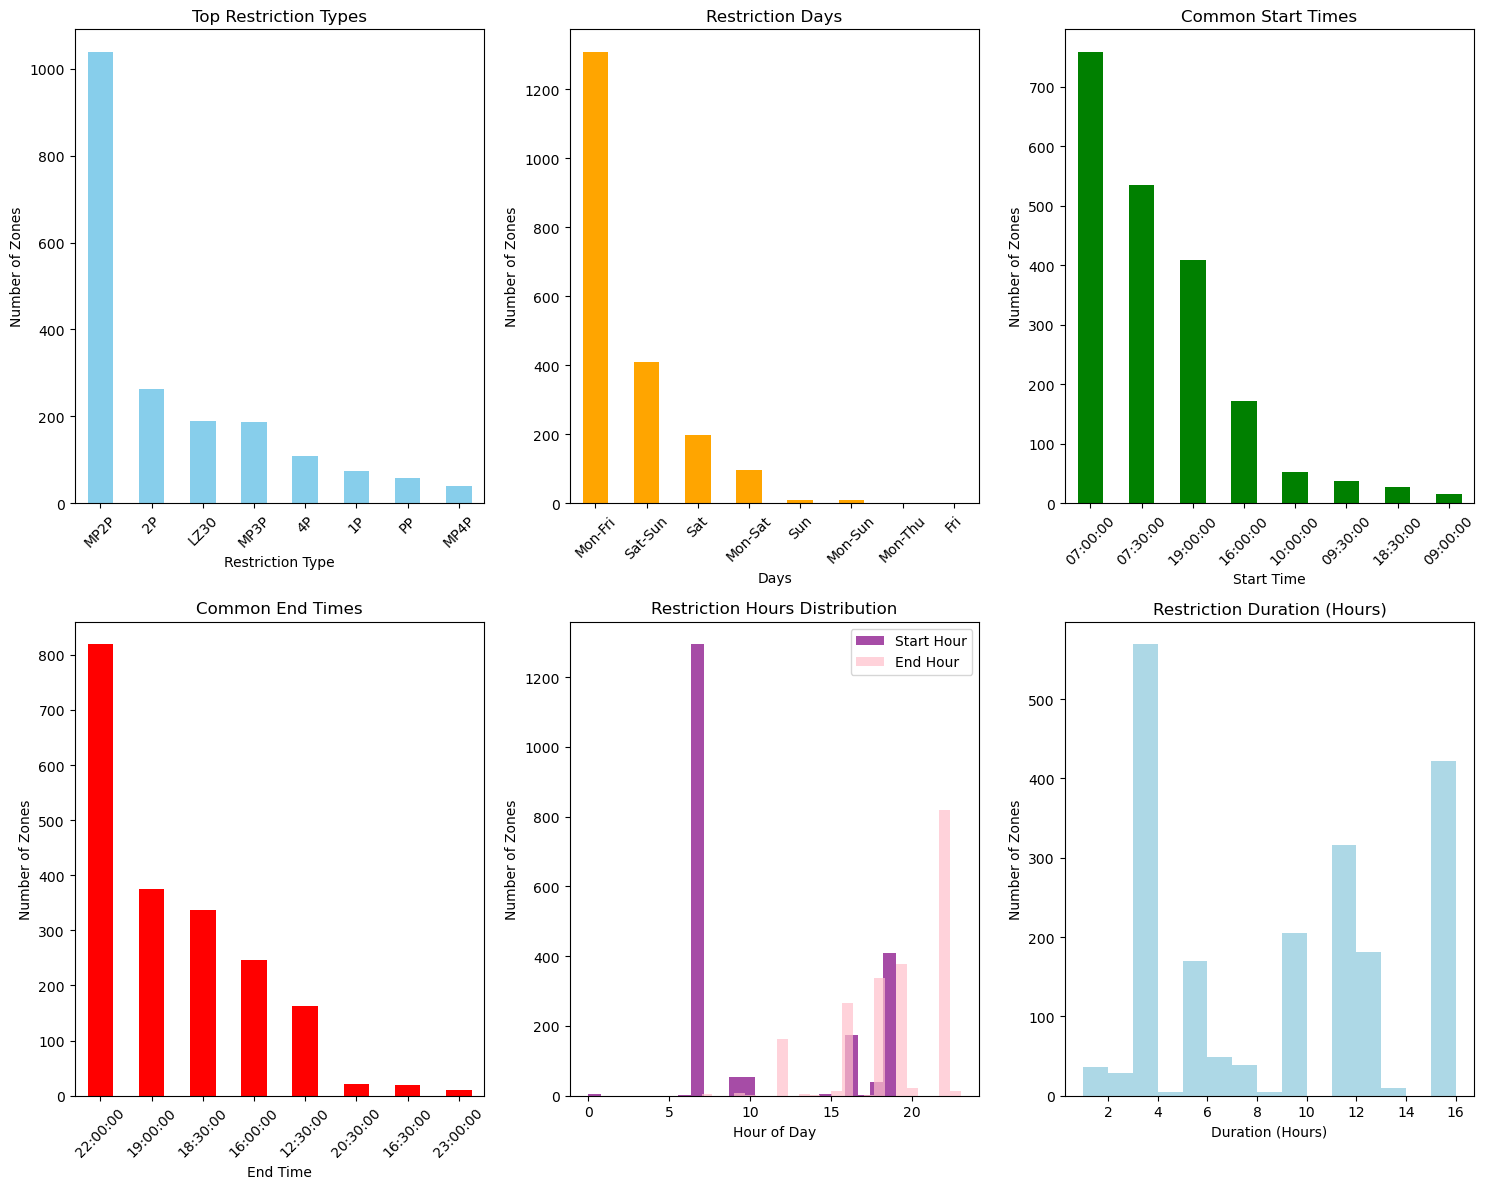

In [18]:
# Create visualizations
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 12))

# 1. Restriction types
plt.subplot(2, 3, 1)
restriction_types.head(8).plot(kind='bar', color='skyblue')
plt.title('Top Restriction Types')
plt.xlabel('Restriction Type')
plt.ylabel('Number of Zones')
plt.xticks(rotation=45)

# 2. Restriction days
plt.subplot(2, 3, 2)
restriction_days.plot(kind='bar', color='orange')
plt.title('Restriction Days')
plt.xlabel('Days')
plt.ylabel('Number of Zones')
plt.xticks(rotation=45)

# 3. Start times
plt.subplot(2, 3, 3)
start_times.plot(kind='bar', color='green')
plt.title('Common Start Times')
plt.xlabel('Start Time')
plt.ylabel('Number of Zones')
plt.xticks(rotation=45)

# 4. End times
plt.subplot(2, 3, 4)
end_times.plot(kind='bar', color='red')
plt.title('Common End Times')
plt.xlabel('End Time')
plt.ylabel('Number of Zones')
plt.xticks(rotation=45)

# 5. Hour distribution
plt.subplot(2, 3, 5)
plt.hist(restrictions_df['start_hour'].dropna(), bins=24, alpha=0.7, color='purple', label='Start Hour')
plt.hist(restrictions_df['end_hour'].dropna(), bins=24, alpha=0.7, color='pink', label='End Hour')
plt.title('Restriction Hours Distribution')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Zones')
plt.legend()

# 6. Restriction duration
plt.subplot(2, 3, 6)
restrictions_df['duration'] = restrictions_df['end_hour'] - restrictions_df['start_hour']
plt.hist(restrictions_df['duration'].dropna(), bins=15, color='lightblue')
plt.title('Restriction Duration (Hours)')
plt.xlabel('Duration (Hours)')
plt.ylabel('Number of Zones')

plt.tight_layout()
plt.show()

## 6. PARKING ZONES TO STREET SEGMENTS ANALYSIS

In [19]:
print("PARKING ZONES TO STREET SEGMENTS ANALYSIS")
print("=" * 50)

print("Zone-to-street dataset overview:")
print(zones_df.info())
print()

# Basic stats
print(f"Total zone-to-street mappings: {len(zones_df)}")
print(f"Unique parking zones: {zones_df['ParkingZone'].nunique()}")
print(f"Unique street names: {zones_df['OnStreet'].nunique()}")
print(f"Unique street segments: {zones_df['Segment_ID'].nunique()}")

# Zones per street analysis
print("\nSTREET ANALYSIS:")
zones_per_street = zones_df.groupby('OnStreet').size().sort_values(ascending=False)
print(f"Average zones per street: {zones_per_street.mean():.1f}")
print(f"Max zones on one street: {zones_per_street.max()}")

print("\nTop 10 streets by number of parking zones:")
for street, count in zones_per_street.head(10).items():
    print(f"  {street}: {count} zones")

print("\nStreets with only 1 zone:")
single_zone_streets = (zones_per_street == 1).sum()
print(f"  {single_zone_streets} streets have only 1 parking zone")

# Zone distribution analysis
print("\nZONE DISTRIBUTION:")
street_segments_per_zone = zones_df.groupby('ParkingZone').size()
print(f"Zones spanning multiple segments: {(street_segments_per_zone > 1).sum()}")
print(f"Zones with single segment: {(street_segments_per_zone == 1).sum()}")

# Street segment analysis
print("\nSTREET SEGMENT ANALYSIS:")
print("Sample street segments with start/end points:")
segment_sample = zones_df[['OnStreet', 'StreetFrom', 'StreetTo', 'ParkingZone']].head(10)
print(segment_sample.to_string())

PARKING ZONES TO STREET SEGMENTS ANALYSIS
Zone-to-street dataset overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798 entries, 0 to 797
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ParkingZone  798 non-null    int64 
 1   OnStreet     798 non-null    object
 2   StreetFrom   798 non-null    object
 3   StreetTo     794 non-null    object
 4   Segment_ID   798 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 31.3+ KB
None

Total zone-to-street mappings: 798
Unique parking zones: 714
Unique street names: 166
Unique street segments: 496

STREET ANALYSIS:
Average zones per street: 4.8
Max zones on one street: 29

Top 10 streets by number of parking zones:
  St Kilda Road: 29 zones
  Collins Street: 24 zones
  Queen Street: 24 zones
  Lonsdale Street: 21 zones
  Bourke Street: 19 zones
  Royal Parade: 18 zones
  Russell Street: 18 zones
  Elizabeth Street: 18 zones
  Victoria Street: 18 zones
  

In [20]:
print("\nDATA QUALITY & RELATIONSHIPS:")
print("=" * 50)

# Check for missing values
print("Missing values:")
for col in zones_df.columns:
    missing = zones_df[col].isnull().sum()
    if missing > 0:
        print(f"  {col}: {missing} missing values")

# Analyze zone coverage compared to other datasets
print(f"\nDATASET RELATIONSHIPS:")

# Compare with sensors data
sensor_zones = set(sensors_df['Zone_Number'].dropna().astype(int))
mapping_zones = set(zones_df['ParkingZone'])
restriction_zones = set(restrictions_df['ParkingZone'])

print(f"Zones in sensors data: {len(sensor_zones)}")
print(f"Zones in street mapping: {len(mapping_zones)}")
print(f"Zones in restrictions data: {len(restriction_zones)}")

# Find overlaps
sensor_mapping_overlap = sensor_zones.intersection(mapping_zones)
sensor_restriction_overlap = sensor_zones.intersection(restriction_zones)
mapping_restriction_overlap = mapping_zones.intersection(restriction_zones)

print(f"\nZONE OVERLAPS:")
print(f"Sensors ∩ Street mapping: {len(sensor_mapping_overlap)} zones")
print(f"Sensors ∩ Restrictions: {len(sensor_restriction_overlap)} zones")
print(f"Street mapping ∩ Restrictions: {len(mapping_restriction_overlap)} zones")

# Complete data availability
complete_zones = sensor_zones.intersection(mapping_zones).intersection(restriction_zones)
print(f"Zones with ALL data types: {len(complete_zones)} zones")
print(f"   (sensors + street names + restrictions)")


DATA QUALITY & RELATIONSHIPS:
Missing values:
  StreetTo: 4 missing values

DATASET RELATIONSHIPS:
Zones in sensors data: 331
Zones in street mapping: 714
Zones in restrictions data: 757

ZONE OVERLAPS:
Sensors ∩ Street mapping: 291 zones
Sensors ∩ Restrictions: 325 zones
Street mapping ∩ Restrictions: 644 zones
Zones with ALL data types: 290 zones
   (sensors + street names + restrictions)


In [21]:
print("\nSTREET PATTERNS ANALYSIS:")
print("=" * 50)

# Analyze street name patterns
print("STREET TYPE ANALYSIS:")
street_types = {}
for street in zones_df['OnStreet'].unique():
    if 'Street' in street:
        street_types['Street'] = street_types.get('Street', 0) + 1
    elif 'Road' in street:
        street_types['Road'] = street_types.get('Road', 0) + 1
    elif 'Avenue' in street:
        street_types['Avenue'] = street_types.get('Avenue', 0) + 1
    elif 'Lane' in street:
        street_types['Lane'] = street_types.get('Lane', 0) + 1
    else:
        street_types['Other'] = street_types.get('Other', 0) + 1

print("Street types distribution:")
for stype, count in sorted(street_types.items(), key=lambda x: x[1], reverse=True):
    print(f"  {stype}: {count} streets")

# Analyze segment descriptions
print(f"\nSTREET SEGMENT PATTERNS:")
print("Sample segment descriptions:")
unique_segments = zones_df['OnStreet'].value_counts()
print("Streets with most complex segment patterns:")
for street, count in unique_segments.head(5).items():
    street_segments = zones_df[zones_df['OnStreet'] == street][['StreetFrom', 'StreetTo', 'ParkingZone']]
    print(f"\n{street} ({count} zones):")
    print(street_segments.head(3).to_string(index=False))


STREET PATTERNS ANALYSIS:
STREET TYPE ANALYSIS:
Street types distribution:
  Street: 103 streets
  Other: 34 streets
  Road: 11 streets
  Lane: 10 streets
  Avenue: 8 streets

STREET SEGMENT PATTERNS:
Sample segment descriptions:
Streets with most complex segment patterns:

St Kilda Road (29 zones):
     StreetFrom        StreetTo  ParkingZone
   Anzac Avenue Coventry Street         7652
Armadale Street Commercial Road         7656
Commercial Road  Moubray Street         7665

Collins Street (24 zones):
      StreetFrom       StreetTo  ParkingZone
Elizabeth Street   Queen Street         7351
     King Street Spencer Street         7357
 Merchant Street  Bourke Street         7186

Queen Street (24 zones):
      StreetFrom         StreetTo  ParkingZone
 Flinders Street    Flinders Lane         7598
 La Trobe Street A'Beckett Street         7604
A'Beckett Street  Franklin Street         7600

Lonsdale Street (21 zones):
    StreetFrom       StreetTo  ParkingZone
William Street    King S